In [1]:
import scanpy as sc
import surgeon

Using TensorFlow backend.


In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = "batch"
cell_type_key = 'celltype'
target_condition = "Batch4"

# Loading four Toy datasets and data preparation

In [4]:
adata = sc.read("./data/toy/toy_count.h5ad")
adata

AnnData object with n_obs × n_vars = 36000 × 5000 
    obs: 'batch', 'celltype'

## Number of cells in each batch

In [5]:
adata.obs[condition_key].value_counts()

Batch9    4000
Batch8    4000
Batch7    4000
Batch6    4000
Batch5    4000
Batch4    4000
Batch3    4000
Batch2    4000
Batch1    4000
Name: batch, dtype: int64

## visualization  of the original data

In [6]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


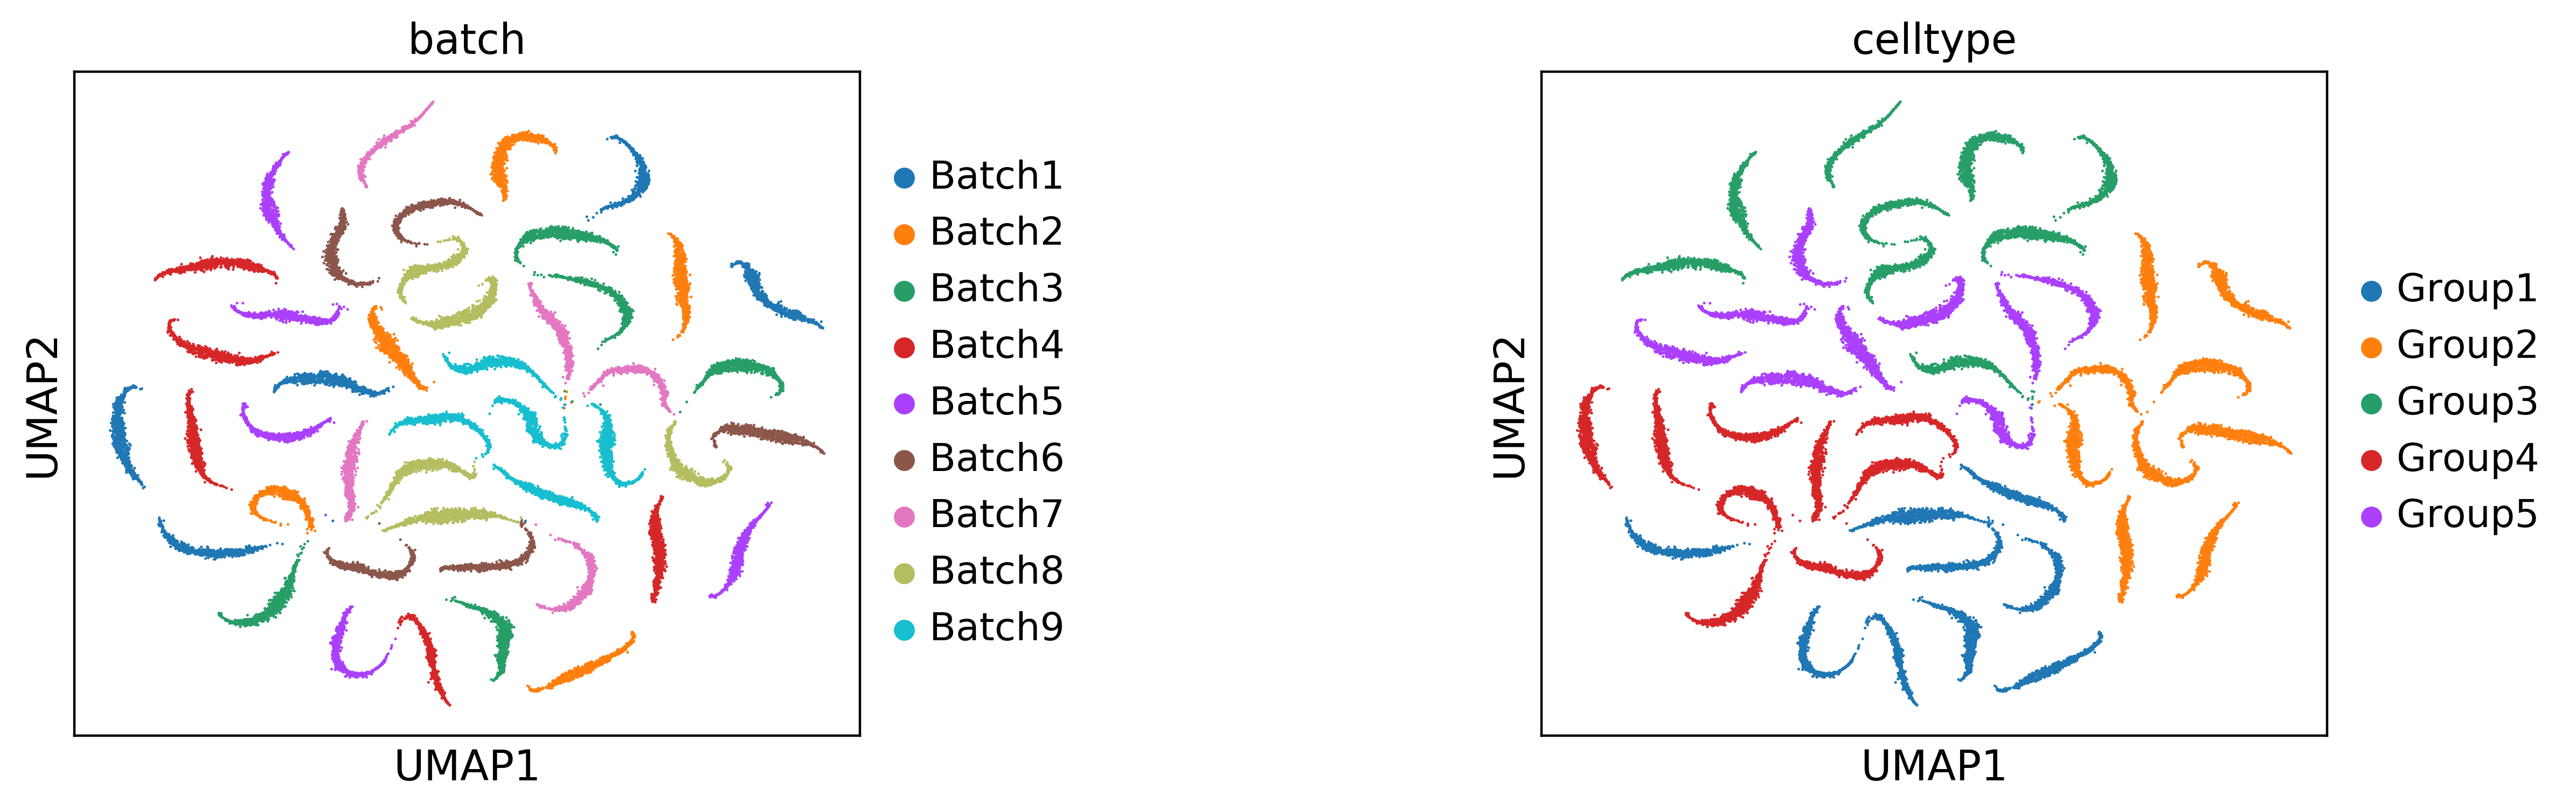

In [7]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.7)

## Now we leave out one study (SS2) for training the newtork

In [8]:
adata_for_training = adata[adata.obs[condition_key] != target_condition]
adata_for_training

View of AnnData object with n_obs × n_vars = 32000 × 5000 
    obs: 'batch', 'celltype'
    uns: 'neighbors', 'batch_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'

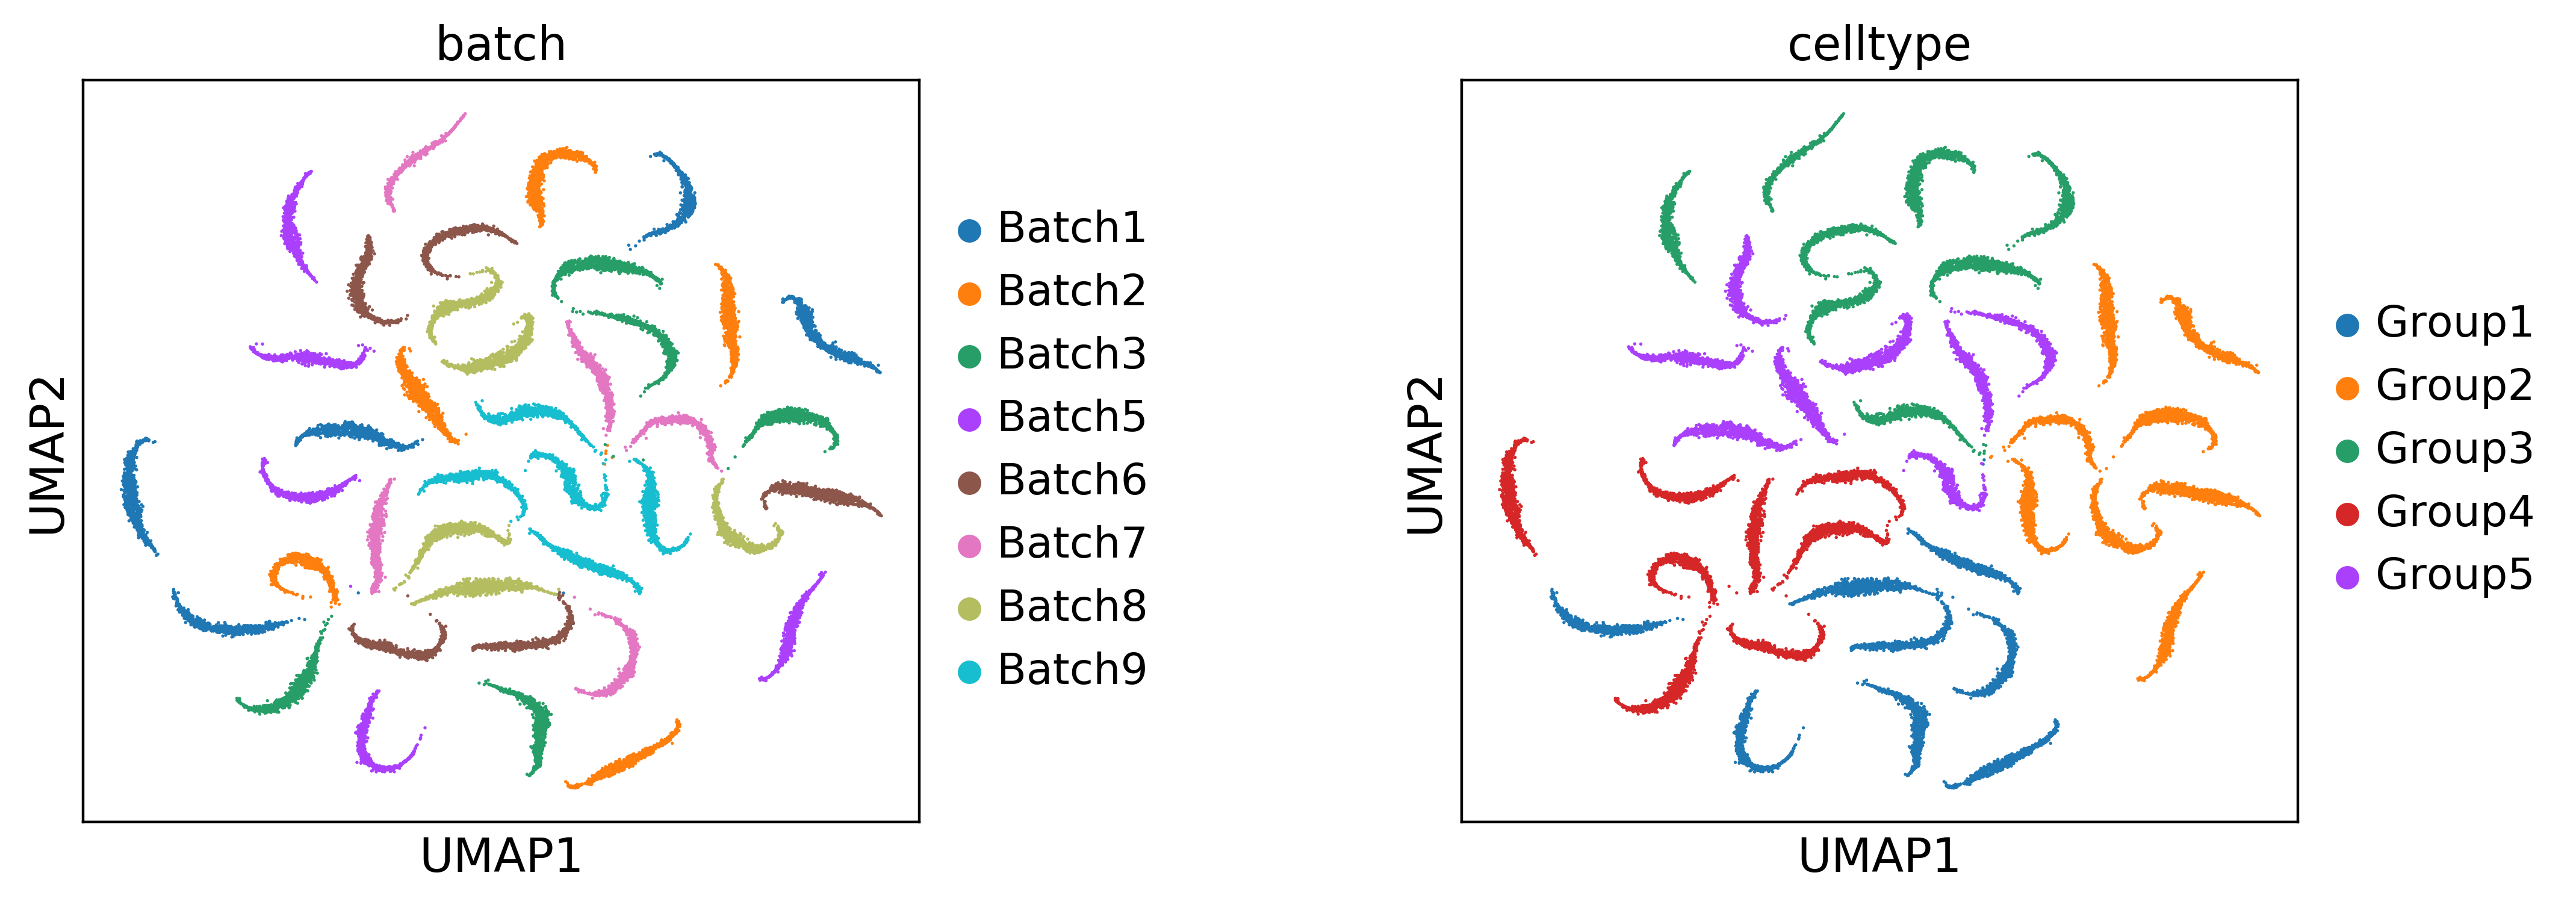

In [9]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [10]:
adata_out_of_sample = adata[adata.obs[condition_key] == target_condition]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 4000 × 5000 
    obs: 'batch', 'celltype'
    uns: 'neighbors', 'batch_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'

## Normalization

In [11]:
adata_for_training = surgeon.utils.normalize(adata_for_training, 
                                             filter_min_counts=False, 
                                             normalize_input=False, 
                                             size_factors=True,
                                             logtrans_input=True,
                                             n_top_genes=2000,
                                            )

In [12]:
adata_out_of_sample = surgeon.utils.normalize(adata_out_of_sample, 
                                              filter_min_counts=False, 
                                              normalize_input=False, 
                                              size_factors=True,
                                              logtrans_input=True,
                                              n_top_genes=2000,
                                             )

Trying to set attribute `.obs` of view, making a copy.


## Train/Test Split

In [13]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [14]:
train_adata.shape, valid_adata.shape

((12750, 2000), (2250, 2000))

In [15]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [16]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=20,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=3.0,
                             loss_fn='nb',
                             model_path="./models/CVAE/Toy_count/",
                             dropout_rate=0.2
                            )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/mohsen/scnet/surgeon/models/_cvae.py:146: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2003)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1025536     concatenate_1[0][0]              
__________

## We assign each study to a numerical label 

In [17]:
conditions = adata.obs[condition_key].unique().tolist()
target_conditions = [target_condition]
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Batch1': 0, 'Batch2': 1, 'Batch3': 2}

## Training the network

In [18]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=200,
              batch_size=128, 
              early_stop_limit=20,
              lr_reducer=15, 
              save=True, 
              verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 12750 samples, validate on 2250 samples
Epoch 1/200
 - 11s - loss: 4.1269 - nb: 4.1269 - val_loss: 3.0368 - val_nb: 3.0368
Epoch 2/200
 - 1s - loss: 2.9928 - nb: 2.9928 - val_loss: 2.9177 - val_nb: 2.9177
Epoch 3/200
 - 1s - loss: 2.9056 - nb: 2.9056 - val_loss: 2.8248 - val_nb: 2.8248
Epoch 4/200
 - 1s - loss: 2.8544 - nb: 2.8544 - val_loss: 2.7726 - val_nb: 2.7726
Epoch 5/200
 - 1s - loss: 2.8115 - nb: 2.8115 - val_loss: 2.7519 - val_nb: 2.7519
Epoch 6/200
 - 1s - loss: 2.7852 - nb: 2.7852 - val_loss: 2.7579 - val_nb: 2.7579
Epoch 7/200
 - 1s - loss: 2.7651 - nb: 2.7651 - val_loss: 2.7088 - val_nb: 2.7088
Epoch 8/200
 - 1s - loss: 2.7515 - nb: 2.7515 - val_loss: 2.7049 - val_nb: 2.7049
Epoch 9/200
 - 1s - loss: 2.7361 - nb: 2.7361 - val_loss: 2.6836 - val_nb: 2.6836
Epoch 10/200
 - 1s - loss: 2.7281 - nb: 2.7281 - val_loss: 2.6875 - val_nb: 2.6875
Epoch 11/200
 - 1s - loss: 2.7225 - nb: 2.7225 - val_loss: 2.6730 - val_nb: 2.673

In [19]:
network.condition_encoder

{'Batch1': 0, 'Batch2': 1, 'Batch3': 2}

In [20]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [21]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 12750 × 20 
    obs: 'batch', 'celltype', 'n_counts', 'size_factors'

In [22]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


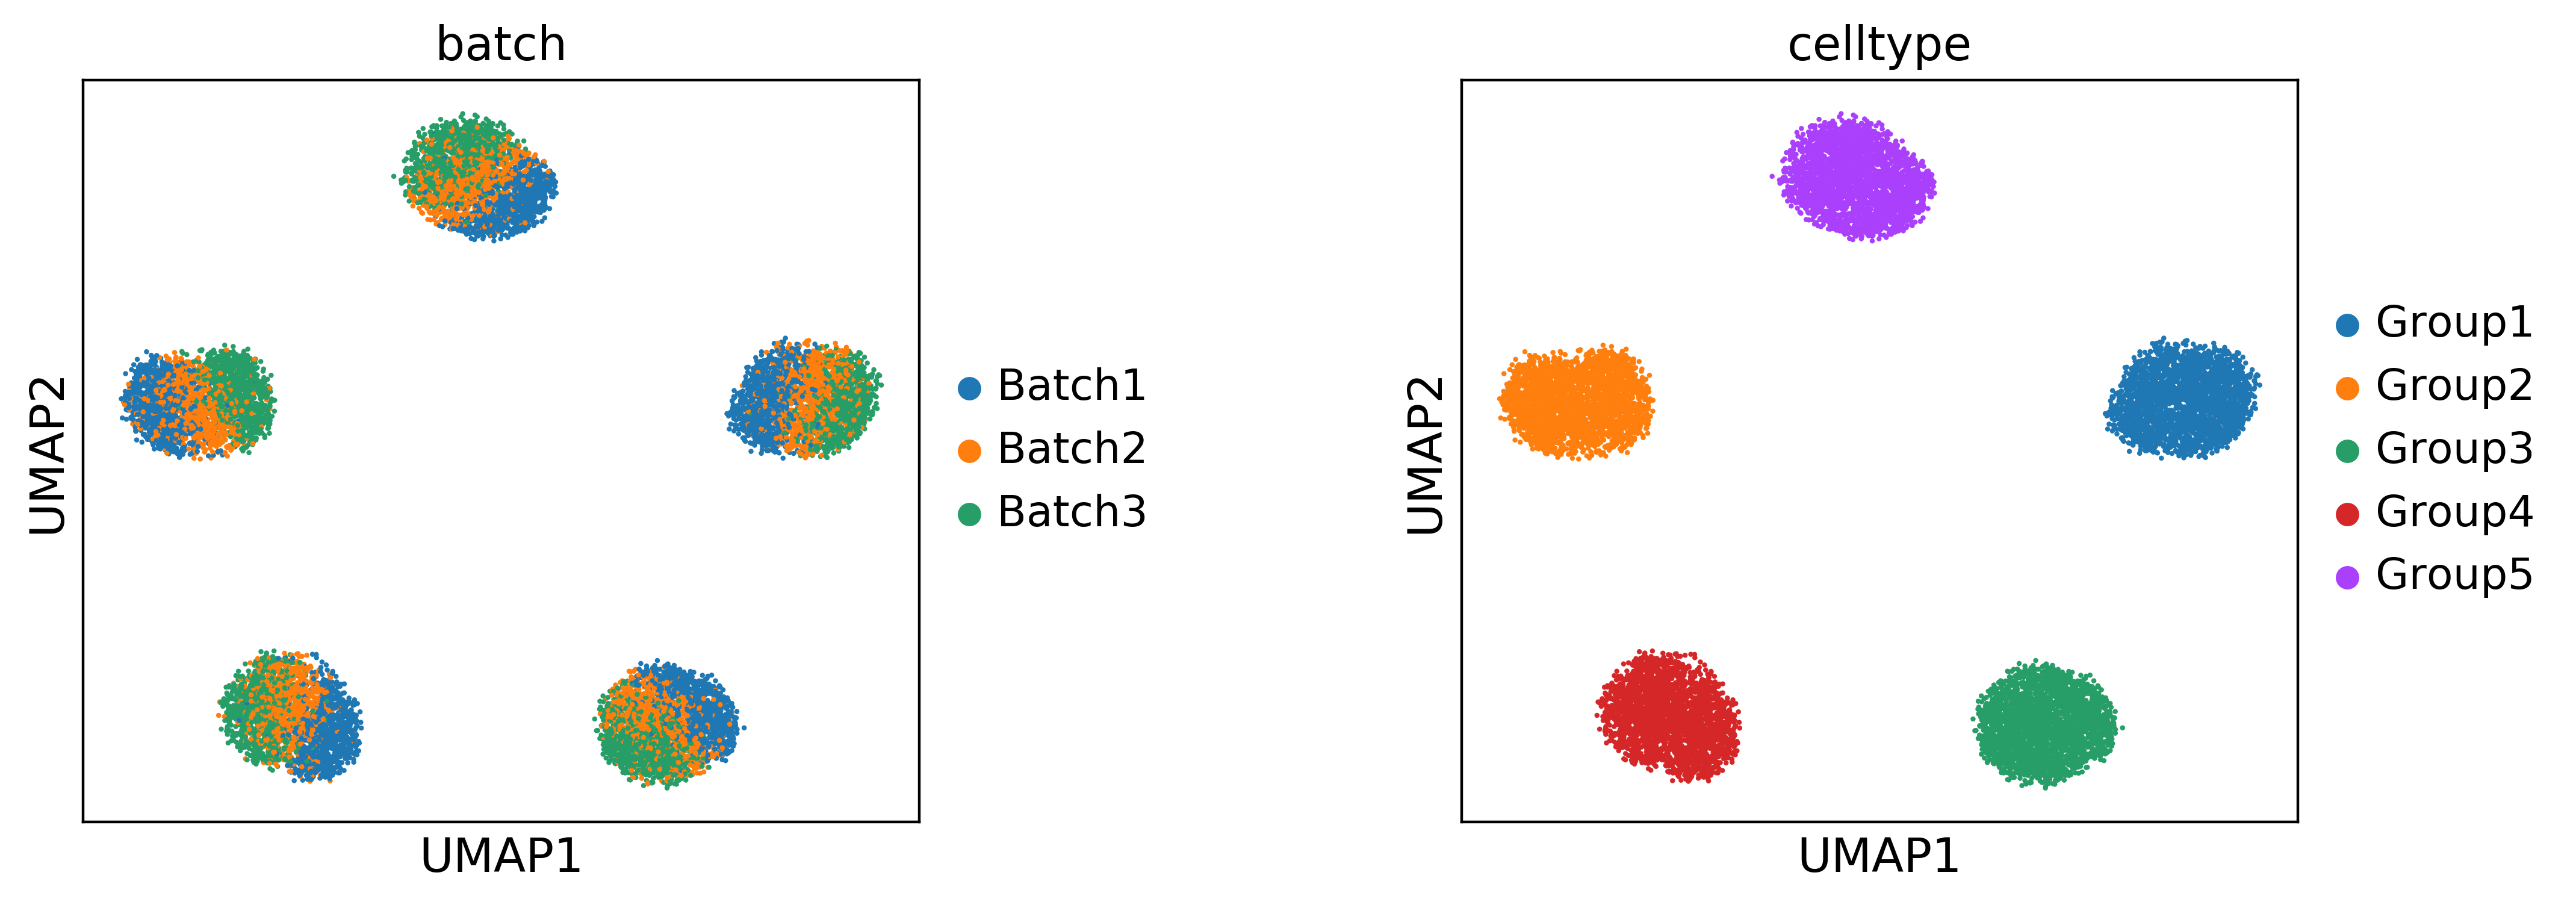

In [23]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [24]:
new_network = surgeon.operate(network, 
                              new_condition=target_condition,
                              init='Xavier', 
                              freeze=True)

/home/mohsen/scnet/surgeon/models/_cvae.py:146: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2004)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1026048     concatenate_3[0][0]              
__________

In [25]:
new_network.condition_encoder

{'Batch1': 0, 'Batch2': 1, 'Batch3': 2, 'Batch4': 3}

## Train with small new dataset containing out-of-sample condition

In [26]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [27]:
train_adata.shape, valid_adata.shape

((4250, 2000), (750, 2000))

In [28]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=100,
                  batch_size=128, 
                  early_stop_limit=25,
                  lr_reducer=20, 
                  save=True, 
                  verbose=2)

Train on 4250 samples, validate on 750 samples
Epoch 1/100
 - 1s - loss: 2.7048 - nb: 2.7048 - val_loss: 2.6816 - val_nb: 2.6816
Epoch 2/100
 - 0s - loss: 2.7018 - nb: 2.7018 - val_loss: 2.6837 - val_nb: 2.6837
Epoch 3/100
 - 0s - loss: 2.6994 - nb: 2.6994 - val_loss: 2.6799 - val_nb: 2.6799
Epoch 4/100
 - 0s - loss: 2.6967 - nb: 2.6967 - val_loss: 2.6792 - val_nb: 2.6792
Epoch 5/100
 - 0s - loss: 2.6943 - nb: 2.6943 - val_loss: 2.6842 - val_nb: 2.6842
Epoch 6/100
 - 0s - loss: 2.6928 - nb: 2.6928 - val_loss: 2.7018 - val_nb: 2.7018
Epoch 7/100
 - 0s - loss: 2.6911 - nb: 2.6911 - val_loss: 2.7036 - val_nb: 2.7036
Epoch 8/100
 - 0s - loss: 2.6889 - nb: 2.6889 - val_loss: 2.6986 - val_nb: 2.6986
Epoch 9/100
 - 0s - loss: 2.6875 - nb: 2.6875 - val_loss: 2.6843 - val_nb: 2.6843
Epoch 10/100
 - 0s - loss: 2.6861 - nb: 2.6861 - val_loss: 2.6782 - val_nb: 2.6782
Epoch 11/100
 - 0s - loss: 2.6862 - nb: 2.6862 - val_loss: 2.6762 - val_nb: 2.6762
Epoch 12/100
 - 0s - loss: 2.6858 - nb: 2.6858 - 

In [29]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(20000, 1)

In [30]:
adata = surgeon.utils.normalize(adata, 
                                 filter_min_counts=False, 
                                 normalize_input=False, 
                                 size_factors=True,
                                 logtrans_input=True,
                                 n_top_genes=2000,
                                )

In [31]:
adata.obs[condition_key].value_counts()

Batch4    5000
Batch3    5000
Batch2    5000
Batch1    5000
Name: batch, dtype: int64

In [32]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 20000 × 20 
    obs: 'batch', 'celltype', 'n_counts', 'size_factors'

In [33]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

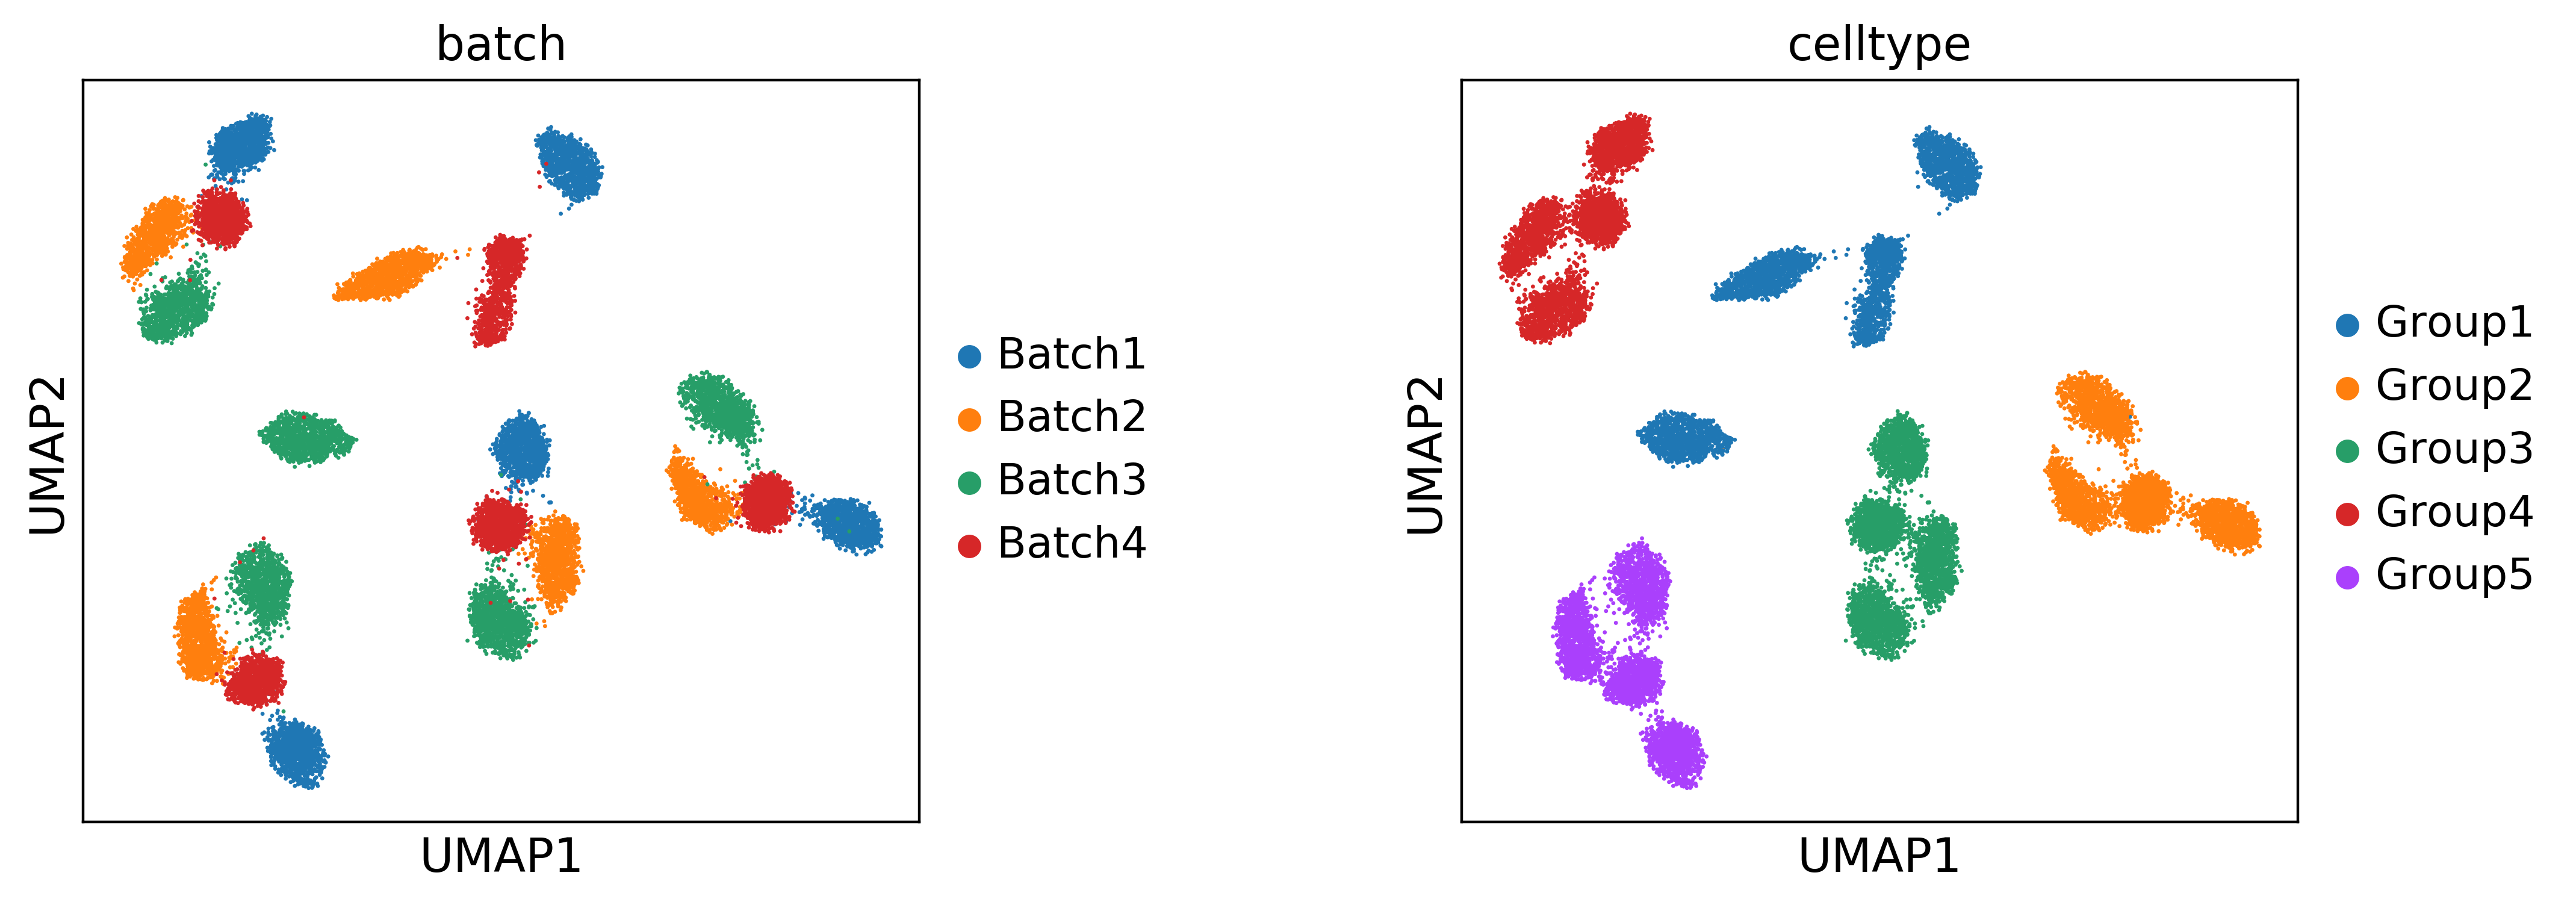

In [34]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [ ]:
surgeon.metrics.entropy_batch_mixing(adata, batch_key=)